In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
data_path = '/Users/niloufar/Desktop/DeepLearning/tf_specialization/comment/'
data1 = 'spam_or_not1.xlsx'
data2 = 'spam_or_not2.xlsx'
data3 = 'spam_or_not3.xlsx'

df1 = pd.read_excel(data_path + data1)
df2 = pd.read_excel(data_path + data2)
df3 = pd.read_excel(data_path + data3)

df = pd.concat([df1, df2, df3], ignore_index=True)
df = df.drop(['ID', df.columns[3]], axis=1)
df.head(18)

,Text (comment),Spam or ham
0,یه مشت لات و لوت جمع کردید تو این اتاق فرار و ...,Spam
1,سناریو اصلا خوب نبود و برای ما نصفه تموم شد - ...,Spam
2,رفتار پرسنل مناسب نبود\n عدم اگاهی رسانی دقیق...,Spam
3,😡😡😡هشدار این یک کلاه برداری علنی است😡😡😡\nخونه ...,Spam
4,اتاق فرار خوبی بود اما نه به اندازه کامنت ها ق...,Spam
5,سلام\nمجوز برای اتاق فرار نداشتند\nبرخورد خوب ...,Spam
6,داستان بازی سر و ته مشخصی نداشت،بیشتر فضا سازی...,Spam
7,در خصوص بازی های اتاق فرار با احترام به کسانی ...,Spam
8,نه مجوز\nنه کوچه مطمئن \nنه محله درست\nنه جای ...,Spam
9,افتضاح خواهشن به كامنت ها توجه نكنيد\nنميدونم ...,Spam


### Sampling

In [3]:
df['labels'] = df.apply(lambda x: x[1].lower(), axis=1)

In [4]:
df = df.drop(columns=df.columns[1], axis=1)

In [5]:
df[df.columns[1]].value_counts()

labels
ham     5520
spam     715
Name: count, dtype: int64

In [6]:
df_grouped_by = df.groupby('labels')
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().max(), replace=True).reset_index(drop=True))
len(df_balanced)

11040

In [7]:
df_balanced[df_balanced.columns[1]].value_counts()

labels
ham     5520
spam    5520
Name: count, dtype: int64

In [8]:
df_balanced.columns[0]

'Text (comment)'

In [9]:
# d = {'class':['c1','c2','c1','c1','c2','c1','c1','c2','c3','c3'],
#      'val': [1,2,1,1,2,1,1,2,3,3]
#     }

# df = pd.DataFrame(d)

# df

In [10]:
# g = df.groupby('class')
# b = g.apply(lambda x: x.sample(g.size().max(), replace=True).reset_index(drop=True))
# b

In [11]:
def remove_stopwords(sentence):
    stopwords = ['که', 'در', 'از', 'به', 'و', 'را', 'این', 'آن', 'بعد', 'همه', 'دوباره', 'یک', 'یه', 'من', 'تو', 'او', 'ما', 'شما', 'قبل', 'آنها', 'زیرا', 'زیر', 'اما', 'بین', 'دو', 'با', 'اونجا',
                'برای', 'حتما','حالی', 'چرا', 'چی', 'ازطریق', 'رو', ',', 'واقعا','ها', 'تو', 'اون', 'ترین', 'توی', 'چه', 'مارو', 'سر', 'اونجا', 'خود', 'هارو', 'آقا', 'همتون', 'هام', 'دوتا', 'دوباره',
                'اگه', 'ولی', 'روش', 'اینو', 'هنوز', 'ده', 'سه', 'چهار', 'پنج', 'شش', 'هفت', 'هشت', 'نه', 'ده', 'نا','ایی']
    words = sentence.split()
    results_words = [word for word in words if word not in stopwords]
    sentence = ' '.join(results_words)
    return sentence

In [12]:
remove_stopwords("پدر سگ را به درخت بست.")

'پدر سگ درخت بست.'

### Reading the raw data

In [13]:
def parse_data_from_file(df):
    sentences = []
    labels = []
    for i,j in zip(df[df.columns[0]], df[df.columns[1]]):
        sentences.append(remove_stopwords(i))
        labels.append(j)
    return sentences, labels

In [14]:
sentences, labels = parse_data_from_file(df_balanced)

In [15]:
print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

There are 11040 sentences in the dataset.

First sentence has 23 words (after removing stopwords).

There are 11040 labels in the dataset.

The first 5 labels are ['ham', 'ham', 'ham', 'ham', 'ham']


In [16]:
NUM_WORDS = 10000 #10894
EMBEDDING_DIM = 64
MAXLEN = 120 #681
PADDING = 'post'
OOV_TOKEN = '<OOV>'
TRAINING_SPLIT = .8

### Training - Validation Split

In [17]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(sentences, labels, test_size=.2)

In [18]:
# def train_val_split(sentences, labels, training_split):
#     train_size = int(len(sentences)*training_split)
#     train_sentences = sentences[:train_size]
#     train_labels = labels[:train_size]
    
#     validation_sentences = sentences[train_size:]
#     validation_labels = labels[train_size:]
#     return train_sentences, validation_sentences, train_labels, validation_labels

In [19]:
# train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 8832 sentences for training.

There are 8832 labels for training.

There are 2208 sentences for validation.

There are 2208 labels for validation.


### Using the Tokenizer

In [20]:
train_labels.count('spam'), val_labels.count('spam')

(4401, 1119)

In [21]:
def fit_tokenizer(sentences, num_words, oov_token):
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    tokenizer.fit_on_texts(sentences)
    return tokenizer

In [22]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(tokenizer.word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in tokenizer.word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 10805 words

<OOV> token included in vocabulary


### Save tokenizer

In [23]:
import pickle
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [24]:
def seq_and_pad(tokenizer, sentences, padding, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)
    return padded_sequences

In [25]:
train_padded_seq = seq_and_pad(tokenizer,train_sentences, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(tokenizer, val_sentences, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (8832, 120)

Padded validation sequences have shape: (2208, 120)


In [26]:
# def tokenize_labels(all_labels, split_labels):
#     label_tokenizer = Tokenizer()
#     label_tokenizer.fit_on_texts(all_labels)
#     label_seq = label_tokenizer.texts_to_sequences(split_labels)
#     label_seq_np = np.array(label_seq) - 1
    
#     return label_seq_np

In [27]:
train_label_seq = np.unique(train_labels, return_inverse=True)[1] # spam==1
train_labels[0], train_label_seq[0]

('ham', 0)

In [28]:
# spam_data['target'] = np.where(spam_data['target']=='spam',1,0)
val_label_seq =np.unique(val_labels, return_inverse=True)[1]  # spam==1
val_labels[0], val_label_seq[0]

('ham', 0)

In [29]:
# train_label_seq = tokenize_labels(labels, train_labels)
# val_label_seq = tokenize_labels(labels, val_labels)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

First 5 labels of the training set should look like this:
[0 1 0 1 1]

First 5 labels of the validation set should look like this:
[0 0 1 0 1]

Tokenized labels of the training set have shape: (8832,)

Tokenized labels of the validation set have shape: (2208,)



### Selecting the model for text classification

In [30]:
def create_model(num_words, embedding_dim, maxlen):
    
    tf.random.set_seed(123)

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=MAXLEN),
#         tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(6, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [31]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 64)           640000    
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 6)                 46086     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 686,093
Trainable params: 686,093
Non-trainable params: 0
_________________________________________________________________


2023-05-09 09:05:20.193701: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-09 09:05:20.194296: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [32]:
history = model.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/30


2023-05-09 09:05:45.273103: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-09 09:05:45.472319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


276/276 [==============================] - 6s 19ms/step - loss: 0.3770 - accuracy: 0.8245 - val_loss: 0.1604 - val_accuracy: 0.9434
Epoch 2/30


2023-05-09 09:05:50.684740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


276/276 [==============================] - 5s 18ms/step - loss: 0.0767 - accuracy: 0.9777 - val_loss: 0.0653 - val_accuracy: 0.9778
Epoch 3/30
276/276 [==============================] - 5s 17ms/step - loss: 0.0254 - accuracy: 0.9926 - val_loss: 0.0420 - val_accuracy: 0.9851
Epoch 4/30
276/276 [==============================] - 4s 16ms/step - loss: 0.0113 - accuracy: 0.9966 - val_loss: 0.0347 - val_accuracy: 0.9887
Epoch 5/30
276/276 [==============================] - 4s 16ms/step - loss: 0.0070 - accuracy: 0.9980 - val_loss: 0.0468 - val_accuracy: 0.9846
Epoch 6/30
276/276 [==============================] - 4s 16ms/step - loss: 0.0049 - accuracy: 0.9985 - val_loss: 0.0394 - val_accuracy: 0.9887
Epoch 7/30
276/276 [==============================] - 4s 16ms/step - loss: 0.0045 - accuracy: 0.9985 - val_loss: 0.0349 - val_accuracy: 0.9887
Epoch 8/30
276/276 [==============================] - 4s 16ms/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 0.0426 - val_accuracy: 0.9891
Epoch 9/30

In [33]:
model.predict(val_padded_seq[1:2])

1/1 [==============================] - 0s 80ms/step


2023-05-09 09:08:07.872196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[2.3370499e-06]], dtype=float32)

In [ ]:
val_label_seq[1:10]

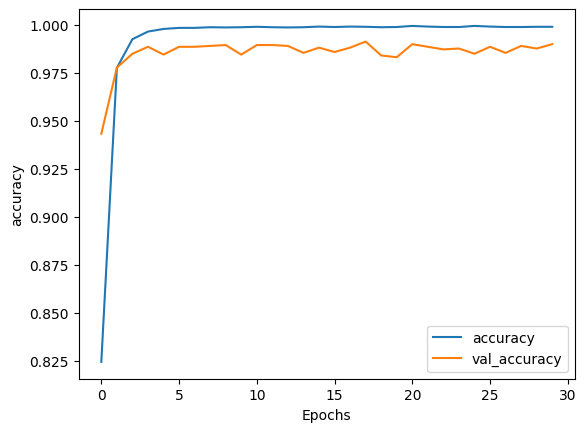

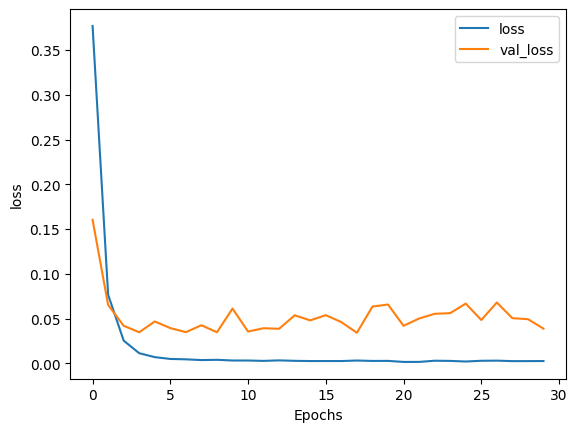

In [34]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")   

### Save the entire model

In [ ]:
# !mkdir -p ../../saved_model
model.save('../../saved_model/my_model')


In [38]:
new_model = tf.keras.models.load_model('../../saved_model/my_model')
new_model.predict(train_padded_seq[1:2])

1/1 [==============================] - 0s 27ms/step


2023-05-08 11:13:10.948468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[0.32601893]], dtype=float32)